# Introduction 

Use this dataset of airline arrival information to predict how late flights
will be. A flight only counts as late if it is more than 30 minutes late.
1. The project should follow guideline as previous projects.
2. Apply models in Naïve Bayes, Logistic Regression, Decision
Tree, Random Forest, Gradient Boosting and SVM.
3. Apply PCA, SelectKBest and RFE for feature selections.
4. Using gridsearchCV to obtain best parameters for models.
5. Compare performances among models, write up analysis
why the model is good or bad in the algorithmic approach
(explain why the algorithm is good or bad for the dataset
structure, can you do something to improve the model?)
6. Include the conclusions.

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
import time 
import datetime
import seaborn as sns

# A quick look of datasets

In [3]:
# load the data
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
data = pd.read_csv("./2008.csv")
data.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,N712SW,128.0,150.0,116.0,-14.0,8.0,IAD,TPA,810,4.0,8.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,N772SW,128.0,145.0,113.0,2.0,19.0,IAD,TPA,810,5.0,10.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,2008,1,3,4,628.0,620,804.0,750,WN,448,N428WN,96.0,90.0,76.0,14.0,8.0,IND,BWI,515,3.0,17.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
3,2008,1,3,4,926.0,930,1054.0,1100,WN,1746,N612SW,88.0,90.0,78.0,-6.0,-4.0,IND,BWI,515,3.0,7.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,N464WN,90.0,90.0,77.0,34.0,34.0,IND,BWI,515,3.0,10.0,0,NaN,0,2.0,0.0,0.0,0.0,32.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7009728 entries, 0 to 7009727
Data columns (total 29 columns):
Year                 int64
Month                int64
DayofMonth           int64
DayOfWeek            int64
DepTime              float64
CRSDepTime           int64
ArrTime              float64
CRSArrTime           int64
UniqueCarrier        object
FlightNum            int64
TailNum              object
ActualElapsedTime    float64
CRSElapsedTime       float64
AirTime              float64
ArrDelay             float64
DepDelay             float64
Origin               object
Dest                 object
Distance             int64
TaxiIn               float64
TaxiOut              float64
Cancelled            int64
CancellationCode     object
Diverted             int64
CarrierDelay         float64
WeatherDelay         float64
NASDelay             float64
SecurityDelay        float64
LateAircraftDelay    float64
dtypes: float64(14), int64(10), object(5)
memory usage: 1.5+ GB


Outlier Detection and Removal

In [5]:
pd.options.display.float_format = "{:.2f}".format

In [6]:
data.describe()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,FlightNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,Cancelled,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
count,7009728.00,7009728.00,7009728.00,7009728.00,6873482.00,7009728.00,6858079.00,7009728.00,7009728.00,6855029.00,7008884.00,6855029.00,6855029.00,6873482.00,7009728.00,6858079.00,6872670.00,7009728.00,7009728.00,1524735.00,1524735.00,1524735.00,1524735.00,1524735.00
mean,2008.00,6.38,15.73,3.92,1333.83,1326.09,1481.26,1494.80,2224.20,127.32,128.87,104.02,8.17,9.97,726.39,6.86,16.45,0.02,0.00,15.77,3.04,17.16,0.07,20.77
std,0.00,3.41,8.80,1.99,478.07,464.25,505.23,482.67,1961.72,70.19,69.41,67.44,38.50,35.31,562.10,4.93,11.33,0.14,0.05,40.10,19.50,31.89,1.84,39.26
min,2008.00,1.00,1.00,1.00,1.00,0.00,1.00,0.00,1.00,12.00,-141.00,0.00,-519.00,-534.00,11.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,2008.00,3.00,8.00,2.00,928.00,925.00,1107.00,1115.00,622.00,77.00,80.00,55.00,-10.00,-4.00,325.00,4.00,10.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,2008.00,6.00,16.00,4.00,1325.00,1320.00,1512.00,1517.00,1571.00,110.00,110.00,86.00,-2.00,-1.00,581.00,6.00,14.00,0.00,0.00,0.00,0.00,6.00,0.00,0.00
75%,2008.00,9.00,23.00,6.00,1728.00,1715.00,1909.00,1907.00,3518.00,157.00,159.00,132.00,12.00,8.00,954.00,8.00,19.00,0.00,0.00,16.00,0.00,21.00,0.00,26.00
max,2008.00,12.00,31.00,7.00,2400.00,2359.00,2400.00,2400.00,9743.00,1379.00,1435.00,1350.00,2461.00,2467.00,4962.00,308.00,429.00,1.00,1.00,2436.00,1352.00,1357.00,392.00,1316.00


Year is always 2008, we can drop Year column. 

In [7]:
data.drop(columns = 'Year', inplace=True)
data.head()

,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,1,3,4,2003.00,1955,2211.00,2225,WN,335,N712SW,128.00,150.00,116.00,-14.00,8.00,IAD,TPA,810,4.00,8.00,0,NaN,0,nan,nan,nan,nan,nan
1,1,3,4,754.00,735,1002.00,1000,WN,3231,N772SW,128.00,145.00,113.00,2.00,19.00,IAD,TPA,810,5.00,10.00,0,NaN,0,nan,nan,nan,nan,nan
2,1,3,4,628.00,620,804.00,750,WN,448,N428WN,96.00,90.00,76.00,14.00,8.00,IND,BWI,515,3.00,17.00,0,NaN,0,nan,nan,nan,nan,nan
3,1,3,4,926.00,930,1054.00,1100,WN,1746,N612SW,88.00,90.00,78.00,-6.00,-4.00,IND,BWI,515,3.00,7.00,0,NaN,0,nan,nan,nan,nan,nan
4,1,3,4,1829.00,1755,1959.00,1925,WN,3920,N464WN,90.00,90.00,77.00,34.00,34.00,IND,BWI,515,3.00,10.00,0,NaN,0,2.00,0.00,0.00,0.00,32.00


In [8]:
# Dữ liệu dạng object 
data.describe(include='O')

,UniqueCarrier,TailNum,Origin,Dest,CancellationCode
count,7009728,6926363,7009728,7009728,137434
unique,20,5373,303,304,4
top,WN,N476HA,ATL,ATL,B
freq,1201754,4701,414513,414521,54904


Now the remained Numeric features are used IQR to check the outliers.

In [9]:
# dataNumeric = data.select_dtypes(include=np.number)
# # Drop FlightNum, it dont have outlier
# dataNumeric.drop(columns = 'FlightNum', inplace=True)

# # get quartile 1st and 3rd
# Q1, Q3 = dataNumeric.quantile(0.25), dataNumeric.quantile(0.75) 
# IQR = Q3 - Q1
# # Boundary
# cutOff = 3*IQR
# # Setup Boudnary
# lower, upper = Q1 - cutOff, Q3 + cutOff # identify Outliers
# for i in dataNumeric:
#     print(dataNumeric[i][(dataNumeric[i] < lower[i]) | (dataNumeric[i] > upper[i])].value_counts().sort_index())
#     print('Total Outliers for ' + i + ' is ' , dataNumeric[i][(dataNumeric[i] < lower[i]) | (dataNumeric[i] > upper[i])].value_counts().sum())
#     print('--------------------------------------------------------------\n')

Check and Fill Missing Value

In [10]:
# Number of missing values in each column
missingValueColumns = (data.isnull().sum())
# Find missing column in data
missingValueColumnsFrame = missingValueColumns[missingValueColumns > 0].to_frame()
# Rename to 0 to Count missingValueColumnsFrame=missingValueColumnsFrame.rename(columns={0:'Count'})
# add percentage column
missingValueColumnsFrame['Percentage'] = missingValueColumnsFrame/data.shape[0] * 100
missingValueColumnsFrame

,0,Percentage
DepTime,136246,1.94
ArrTime,151649,2.16
TailNum,83365,1.19
ActualElapsedTime,154699,2.21
CRSElapsedTime,844,0.01
AirTime,154699,2.21
ArrDelay,154699,2.21
DepDelay,136246,1.94
TaxiIn,151649,2.16
TaxiOut,137058,1.96


In [11]:
data['CancellationCode'].fillna('0', inplace = True)
data['CarrierDelay'].fillna(0, inplace = True)

data['WeatherDelay'].fillna(0, inplace = True)
data['NASDelay'].fillna(0, inplace = True)
data['SecurityDelay'].fillna(0, inplace = True)
data['LateAircraftDelay'].fillna(0, inplace = True)

In [12]:
data.dropna(inplace = True)
data.isnull().sum()

Month                0
DayofMonth           0
DayOfWeek            0
DepTime              0
CRSDepTime           0
ArrTime              0
CRSArrTime           0
UniqueCarrier        0
FlightNum            0
TailNum              0
ActualElapsedTime    0
CRSElapsedTime       0
AirTime              0
ArrDelay             0
DepDelay             0
Origin               0
Dest                 0
Distance             0
TaxiIn               0
TaxiOut              0
Cancelled            0
CancellationCode     0
Diverted             0
CarrierDelay         0
WeatherDelay         0
NASDelay             0
SecurityDelay        0
LateAircraftDelay    0
dtype: int64

In [13]:
def transformAttrition(value):
    if (value >= 30):
        return 1
    return 0
        
data['LateArr'] = data['ArrDelay'].apply(lambda x: transformAttrition(x))
data.head()

,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,LateArr
0,1,3,4,2003.00,1955,2211.00,2225,WN,335,N712SW,128.00,150.00,116.00,-14.00,8.00,IAD,TPA,810,4.00,8.00,0,0,0,0.00,0.00,0.00,0.00,0.00,0
1,1,3,4,754.00,735,1002.00,1000,WN,3231,N772SW,128.00,145.00,113.00,2.00,19.00,IAD,TPA,810,5.00,10.00,0,0,0,0.00,0.00,0.00,0.00,0.00,0
2,1,3,4,628.00,620,804.00,750,WN,448,N428WN,96.00,90.00,76.00,14.00,8.00,IND,BWI,515,3.00,17.00,0,0,0,0.00,0.00,0.00,0.00,0.00,0
3,1,3,4,926.00,930,1054.00,1100,WN,1746,N612SW,88.00,90.00,78.00,-6.00,-4.00,IND,BWI,515,3.00,7.00,0,0,0,0.00,0.00,0.00,0.00,0.00,0
4,1,3,4,1829.00,1755,1959.00,1925,WN,3920,N464WN,90.00,90.00,77.00,34.00,34.00,IND,BWI,515,3.00,10.00,0,0,0,2.00,0.00,0.00,0.00,32.00,1


In [14]:
# Data exploration 

In [15]:
# function that extract statistical parameters from a grouby objet:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}
#_______________________________________________________________
# Creation of a dataframe with statitical infos on each airline:
global_stats = data['ArrDelay'].groupby(data['UniqueCarrier']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')
global_stats

,count,max,mean,min
UniqueCarrier,,,,
AQ,7752.00,338.00,-2.89,-90.00
HA,61212.00,1050.00,1.26,-519.00
F9,95384.00,809.00,6.11,-67.00
AS,148492.00,948.00,4.80,-81.00
OH,190692.00,955.00,11.82,-81.00
B6,192114.00,834.00,11.08,-83.00
YV,245131.00,606.00,11.78,-73.00
9E,254320.00,1143.00,4.11,-66.00
FL,258713.00,1175.00,9.09,-86.00


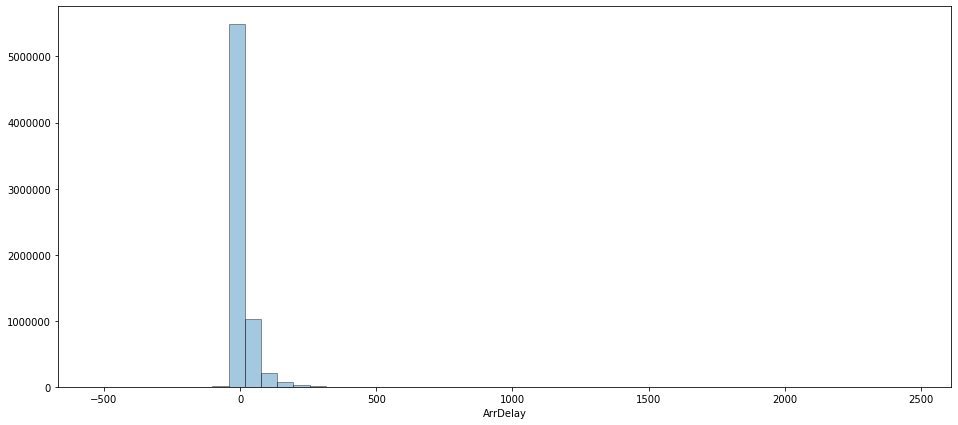

In [16]:
plt.figure(figsize=(16,7))
#plt.xlim(-100,100)
sns.distplot(data['ArrDelay'], kde = False,hist_kws=dict(edgecolor="k"))


In [17]:
# numerical = data.select_dtypes(include = [np.number])

# %config InlineBackend.figure_format = 'png'
# #Plot numerical data against ArrDelay
# fig, axes = plt.subplots(8, 3, figsize=(12, 24))

# for idx, feat in enumerate(numerical.columns.difference(['ArrDelay'])):
#     ax = axes[int(idx / 3), idx%3]
#     sns.scatterplot(x=feat, y='ArrDelay', data=numerical, ax=ax);
#     ax.set_xlabel(feat)
#     ax.set_ylabel('ArrDelay')
    
# fig.tight_layout();

Text(0.5, 1, 'Variable Correlation')

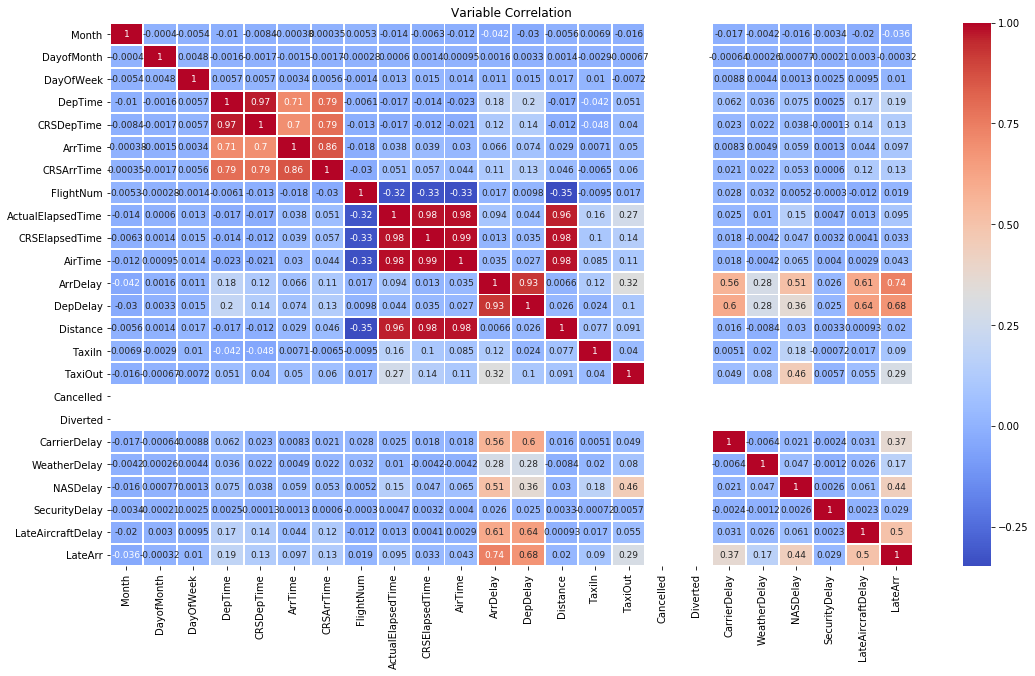

In [18]:
plt.figure(figsize=(18,10))
sns.heatmap(data.corr(),cmap = 'coolwarm',linewidth = 1,annot= True, annot_kws={"size": 9})
plt.title('Variable Correlation')

Base on above Correlation, I will drop columns that have very high Correlation

In [19]:
dataLateArr = data[ data['LateArr']==1]
dataNotLateArr = data[ data['LateArr']==0]
dataLateArr.head()

,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,LateArr
4,1,3,4,1829.00,1755,1959.00,1925,WN,3920,N464WN,90.00,90.00,77.00,34.00,34.00,IND,BWI,515,3.00,10.00,0,0,0,2.00,0.00,0.00,0.00,32.00,1
6,1,3,4,1937.00,1830,2037.00,1940,WN,509,N763SW,240.00,250.00,230.00,57.00,67.00,IND,LAS,1591,3.00,7.00,0,0,0,10.00,0.00,0.00,0.00,47.00,1
11,1,3,4,1644.00,1510,1845.00,1725,WN,1333,N334SW,121.00,135.00,107.00,80.00,94.00,IND,MCO,828,6.00,8.00,0,0,0,8.00,0.00,0.00,0.00,72.00,1
19,1,3,4,1416.00,1325,1512.00,1435,WN,54,N643SW,56.00,70.00,49.00,37.00,51.00,ISP,BWI,220,2.00,5.00,0,0,0,12.00,0.00,0.00,0.00,25.00,1
26,1,3,4,1422.00,1255,1657.00,1610,WN,188,N215WN,155.00,195.00,143.00,47.00,87.00,ISP,FLL,1093,6.00,6.00,0,0,0,40.00,0.00,0.00,0.00,7.00,1


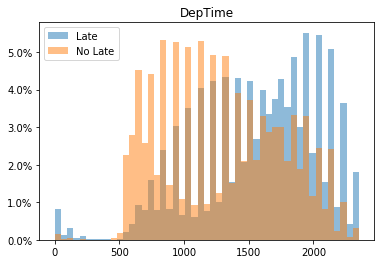

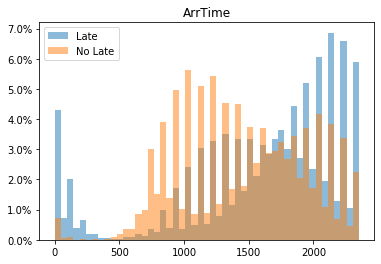

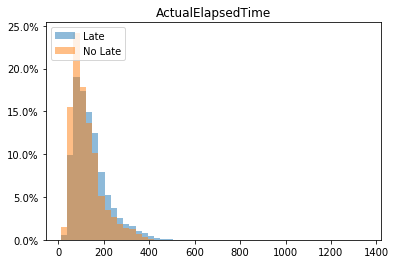

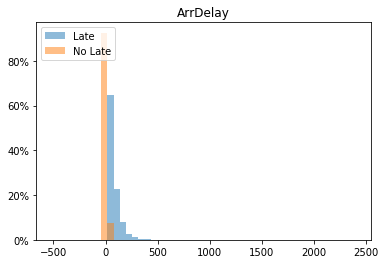

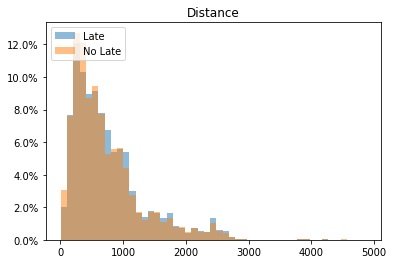

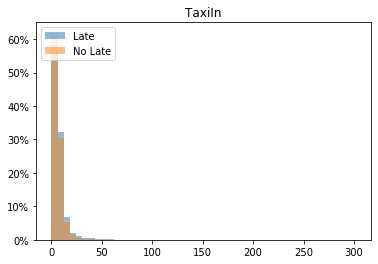

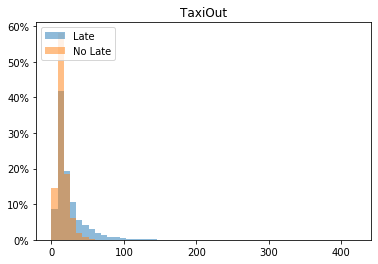

In [23]:
from matplotlib.ticker import PercentFormatter
columns = ['DepTime', 'ArrTime', 'ActualElapsedTime', 'ArrDelay', 'Distance', 'TaxiIn', 'TaxiOut']
for column in columns:
    bins = np.arange(start=data[column].min(), stop=data[column].max(), step=(data[column].max()-data[column].min())/50)
    plt.hist(dataLateArr[column], alpha=0.5, label='Late', bins=bins, weights = np.ones(len(dataLateArr[column])) / len(dataLateArr[column]))
    plt.hist(dataNotLateArr[column], alpha=0.5, label='No Late', bins=bins, weights = np.ones(len(dataNotLateArr[column])) / len(dataNotLateArr[column]))
    plt.legend(loc='upper left')
    plt.title(column)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.show()

Nhìn vào phân phối trên, các biến có ảnh hưởng đến ArrDelay là DepTime, ArrTime, ArrDelay, TaxiOut 

# Apply Model 

# Naive Bayes 


In [28]:
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split


X = data[['DepTime', 'ArrTime', 'ArrDelay', 'TaxiOut']]
Y = data['LateArr']

# Train, test, split
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = .20, random_state= 0)

clf = GaussianNB()
clf.fit(X_train, y_train)
GaussianNB(priors=None, var_smoothing=1e-09)



print(clf.score(X_test, y_test))

0.9681941349593911


Mean of accuracy is 0.97

In [ ]:
# Logistic Regression 

In [30]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)

lg_score = model.score(X_test, y_test)
print(lg_score)

/Users/hung/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9942312391275013


In [ ]:
Mean accuracy is 0.99, higher than Naive Bayes

# Conclusion

In [ ]:
Logistic Regression give the best result 

# Reference

## Imbalance: 
dữ liệu ko cân bằng, sl số 1 và 0 là rất khác nhau ( giả sử 0 rất nhiều 90%)
Model mình ko làm gì cả và phán tất cả là 0 

P = 0.9
R = 0 (recall)
=> F(0) = 0 ko học dc gì
### Cách 1: Tìm thuật toán robust with imbalance: decision tree , naive bayes, knn 

### Cách 2: Điều chỉnh threshold
Logistic regression:
>0.5 coi như 1, < 0.5 coi như 0 
predict_proba() -> xác suất là số 1, 0

Điều chỉnh threshold của model 0.3

### Cách 3: Điều chỉnh cost function 
cost = y*log(1-y) + (1-y)log(1-y)
ylog(1-y) : là số 1
(1-y)log(1-y) : là số 0
Để thay đổi cost mình nhân thêm tham số alpha
cost = alpha*y*log(1-y) + (1-alpha)(1-y)log(1-y)
Tức là nếu dự đoán sai số 1, thì cost lớn hơn nhiều so với dự đoán sai số 0


### Cách 4: resampling
Chọn radom 10 làn trong data số 0
- up sample 
- down sample 

Logistic regression

Logistic regression: số thực 
Naive bayes, decision tree: category 


Gaussian
Multinomial: category nhiều hơn 2
Complement
Bernoulli: phân loại 0,1
        